### Import libaries for data preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### Read files

In [2]:
movies=pd.read_csv('movies.csv')
ratings=pd.read_csv('ratings.csv')

In [3]:
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Extract movie release year

<AxesSubplot: title={'center': 'Frequency of ratings of movies based on release year'}, ylabel='Frequency'>

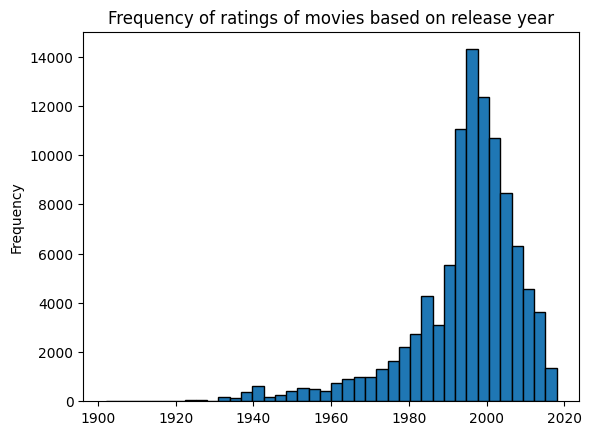

In [5]:
movies["year"]=movies["title"].str.extract(r'\((\d{4})\)')
merged_df = pd.merge(movies, ratings, on='movieId')

merged_df[merged_df['year'].astype(str).str.isdigit()].year.astype(int).plot(kind="hist", bins=40, edgecolor="black", title="Frequency of ratings of movies based on release year")

### Create category generalizing movie release year

In [6]:
def assign_category(row):
    try:
        if int(row['year']) < 2000:
            return 'old'
        else:
            return 'new'
    except:
        return 'unknown'

merged_df['category'] = merged_df.apply(assign_category, axis=1)
merged_df.tail(4)

,movieId,title,genres,year,userId,rating,timestamp,category
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,2017,184,3.5,1537109545,new
100833,193585,Flint (2017),Drama,2017,184,3.5,1537109805,new
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,2018,184,3.5,1537110021,new
100835,193609,Andrew Dice Clay: Dice Rules (1991),Comedy,1991,331,4.0,1537157606,old


### Calculate mean rating of a movie release year category by unique users

In [7]:
result = merged_df.groupby(['userId', 'category'])['rating'].mean().reset_index()
result.head(5)

,userId,category,rating
0,1,new,4.600000
1,1,old,4.361233
2,2,new,3.961538
3,2,old,3.833333
4,3,new,0.500000


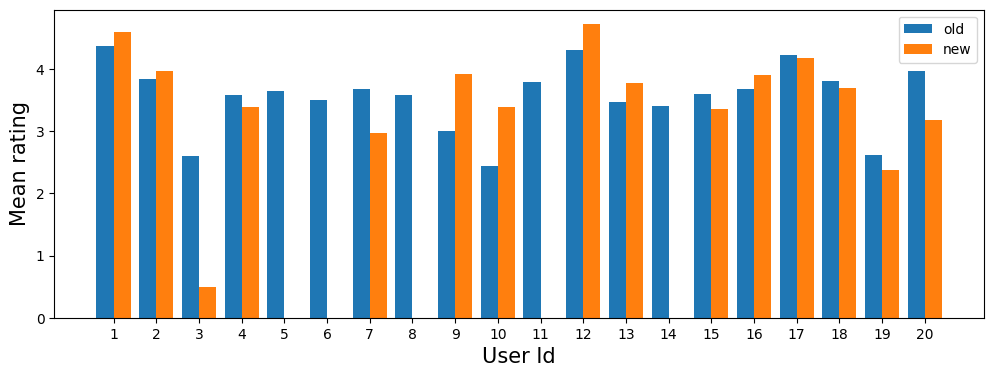

In [8]:
unique_users = result.userId.unique()
mask = lambda x, y: (result.userId==x) & (result.category==y)

# Choose range of userId we want to plot (inclusive)
limit_x = 1
limit_y = 20
unique_limit = unique_users[limit_x-1:limit_y]

plt.figure(figsize=(12,4))

barwidth = 0.4
plt.bar(x=unique_limit-barwidth/2, height=[result[mask(x, "old")].rating.values[0] if not result[mask(x, "old")].rating.empty else 0 for x in unique_limit],
         label="old", width=barwidth)
plt.bar(x=unique_limit+barwidth/2, height=[result[mask(x, "new")].rating.values[0] if not result[mask(x, "new")].rating.empty else 0 for x in unique_limit],
         label="new", width=barwidth)

plt.xlabel('User Id', fontsize = 15)
plt.ylabel('Mean rating', fontsize = 15)
plt.xticks([r+1 for r in range(limit_x-1, limit_y)], unique_limit)
 
plt.legend()
plt.show()

### Binarize release year category according to mean rating (avg_rating>4=1)

In [9]:
def assign_binary(row):
    if row['category'] == 'old':
        return [int(row['rating'] > 4), 0]
    else:
        return [0, int(row['rating'] > 4)]

result[['old', 'new']] = result.apply(assign_binary, axis=1, result_type='expand')
new_result = result.groupby('userId')[['old', 'new']].max().reset_index()
new_result.tail(10)

,userId,old,new
600,601,1,1
601,602,0,0
602,603,0,0
603,604,0,0
604,605,0,0
605,606,0,0
606,607,0,0
607,608,0,0
608,609,0,0
609,610,1,0


### Find genres watched by a user with mean rating above 4

In [10]:
new_merged = merged_df.set_index(['userId', 'rating'])['genres'].str.split('|', expand=True).stack().reset_index(name='genres').drop('level_2', axis=1)
new_merged = new_merged.groupby(['userId', 'genres'])['rating'].mean().reset_index()

new_merged['rating'] = (new_merged['rating'] > 4).astype(int)
new_merged.head(20)

,userId,genres,rating
0,1,Action,1
1,1,Adventure,1
2,1,Animation,1
3,1,Children,1
4,1,Comedy,1
5,1,Crime,1
6,1,Drama,1
7,1,Fantasy,1
8,1,Film-Noir,1
9,1,Horror,0


In [11]:
result = new_merged.pivot(index='userId', columns='genres', values='rating').reset_index().fillna(0)
result=result.drop(columns=["(no genres listed)"])
result.head(5)

genres,userId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Join tables

In [12]:
joined_movies_genres = pd.merge(new_result, result, on='userId')
joined_movies_genres.head(5)

,userId,old,new,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2,0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Count when the reviews were submitted by a user based on day of the week

In [13]:
merged_df['day_of_the_week'] = pd.to_datetime(merged_df['timestamp'], unit='s').dt.dayofweek
merged_df.head(5)

,movieId,title,genres,year,userId,rating,timestamp,category,day_of_the_week
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,1,4.0,964982703,old,6
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,5,4.0,847434962,old,4
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,7,4.5,1106635946,old,1
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,15,2.5,1510577970,old,0
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,17,4.5,1305696483,old,2


In [14]:
result = merged_df.groupby(['userId', 'day_of_the_week']).size().reset_index(name='count')
result.head(5)

,userId,day_of_the_week,count
0,1,1,1
1,1,6,231
2,2,5,29
3,3,4,39
4,4,0,86


### Consider days of the week when most reviews were submitted

In [15]:
max_counts = result.groupby('userId')['count'].transform('max')

filtered_df = result[result['count'] == max_counts]
filtered_df.head(5)

,userId,day_of_the_week,count
1,1,6,231
2,2,5,29
3,3,4,39
4,4,0,86
9,5,4,44


### Binarize review count data

In [16]:
new_df = pd.DataFrame({'userId': filtered_df['userId']})

days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for day in days_of_week:
    new_df[day] = 0

new_df.head(5)

,userId,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
1,1,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0
9,5,0,0,0,0,0,0,0


In [17]:
for _, row in filtered_df.iterrows():
    new_df_row = new_df[new_df['userId'] == row['userId']]
    
    new_df.at[new_df_row.index[0], days_of_week[row['day_of_the_week']]] = 1

new_df.head(5)

,userId,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
1,1,0,0,0,0,0,0,1
2,2,0,0,0,0,0,1,0
3,3,0,0,0,0,1,0,0
4,4,1,0,0,0,0,0,0
9,5,0,0,0,0,1,0,0


### Join tables

In [18]:
joined_days_of_week=pd.merge(joined_movies_genres, new_df, on='userId')

In [19]:
joined_days_of_week

,userId,old,new,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Thriller,War,Western,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,1,1,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,0,0,0,0,0,0,1
1,2,0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0,0,0,0,0,1,0
2,3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0,0,0,0,1,0,0
3,4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,0,0,0,0,0,0
4,5,0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,606,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,1,0,0,0,0,0
607,607,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0,0,0,0,0,1,0
608,608,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,1,0,0,0,0,0
609,609,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,1,0,0,0,0,0


### Discretize ratings created by a user for every movie on a scale (low|medium|high)

In [20]:
user_movie_df = pd.pivot_table(ratings, index='userId', columns='movieId', values='rating')

user_movie_df.fillna(-1, inplace=True)

def discretize_review(review):
    if review==-1:
        return "none"
    elif review<3:
        return 'low'
    elif review == 3:
        return 'medium'
    else:
        return 'high'

user_movie_df["userId"]=user_movie_df.index
df_melt = pd.melt(user_movie_df, id_vars='userId', var_name='movie_id', value_name='review')

# Discretize the review values
df_melt['review'] = df_melt['review'].apply(discretize_review)
df_melt["movie_review"]=df_melt["movie_id"].astype(str)+" "+df_melt["review"]
df_melt.drop('review',axis=1,inplace=True)
df_melt.drop('movie_id',axis=1,inplace=True)
df_melt = df_melt[~df_melt['movie_review'].str.contains('none')]

df_melt.head(5)

,userId,movie_review
0,1,1 high
4,5,1 high
6,7,1 high
14,15,1 low
16,17,1 high


In [21]:
# Pivot the dataframe
df_pivot = df_melt.pivot_table(index='userId', columns='movie_review', aggfunc=len, fill_value=0)
df_pivot.head(5)

movie_review,1 high,1 low,1 medium,10 high,10 low,10 medium,100 high,100 low,100 medium,100044 high,...,99846 medium,99853 high,999 high,999 low,999 medium,99910 high,99910 medium,99917 high,99917 medium,99992 medium
userId,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Create final dataframe

In [22]:
final_df = pd.merge(joined_days_of_week, df_pivot, on='userId')

In [23]:
final_df = final_df.drop(columns=['userId'])

In [24]:
import numpy as np
final_df.columns = np.concatenate((final_df.columns[:28], [movies[movies.movieId == int(x.split(" ")[0])].title.values[0] + " " + x.split(" ")[1] for x in final_df.columns[28:]]))

In [25]:
final_df.head(5)

,old,new,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Everything or Nothing: The Untold Story of 007 (2012) medium,Codependent Lesbian Space Alien Seeks Same (2011) high,2 Days in the Valley (1996) high,2 Days in the Valley (1996) low,2 Days in the Valley (1996) medium,"Last Stand, The (2013) high","Last Stand, The (2013) medium",Upstream Color (2013) high,Upstream Color (2013) medium,Shadow Dancer (2012) medium
0,1,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
final_df = final_df.astype(bool)

In [28]:
final_df

,old,new,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Everything or Nothing: The Untold Story of 007 (2012) medium,Codependent Lesbian Space Alien Seeks Same (2011) high,2 Days in the Valley (1996) high,2 Days in the Valley (1996) low,2 Days in the Valley (1996) medium,"Last Stand, The (2013) high","Last Stand, The (2013) medium",Upstream Color (2013) high,Upstream Color (2013) medium,Shadow Dancer (2012) medium
0,True,True,True,True,True,True,True,True,False,True,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
607,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
608,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
609,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Run apriori algorithm to find frequent itemsets

In [29]:
from mlxtend.frequent_patterns import apriori

frequent_itemsets = apriori(final_df, min_support=0.2, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.260229,(old)
1,0.209493,(new)
2,0.235679,(Adventure)
3,0.230769,(Animation)
4,0.207856,(Children)
...,...,...
88,0.232406,(Lord of the Rings: The Fellowship of the Ring...
89,0.225859,"(Lord of the Rings: The Return of the King, Th..."
90,0.204583,"(Shawshank Redemption, The (1994) high, Forres..."
91,0.204583,"(Silence of the Lambs, The (1991) high, Shawsh..."


### Find association rules

In [30]:
from mlxtend.frequent_patterns import association_rules

rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.2)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Crime),(old),0.335516,0.260229,0.206219,0.614634,2.361896,0.118908,1.919659,0.867757
1,(old),(Crime),0.260229,0.335516,0.206219,0.792453,2.361896,0.118908,3.201607,0.779446
2,(Drama),(old),0.312602,0.260229,0.211129,0.675393,2.595377,0.129781,2.278972,0.894241
3,(old),(Drama),0.260229,0.312602,0.211129,0.811321,2.595377,0.129781,3.643208,0.830932
4,(Drama),(Crime),0.312602,0.335516,0.234043,0.748691,2.231465,0.129160,2.644094,0.802831
...,...,...,...,...,...,...,...,...,...,...
93,(Lord of the Rings: The Fellowship of the Ring...,"(Lord of the Rings: The Return of the King, Th...",0.229133,0.261866,0.216039,0.942857,3.600536,0.156037,12.917349,0.936949
94,"(Lord of the Rings: The Return of the King, Th...",(Lord of the Rings: The Fellowship of the Ring...,0.225859,0.274959,0.216039,0.956522,3.478778,0.153937,16.675941,0.920431
95,(Lord of the Rings: The Fellowship of the Ring...,"(Lord of the Rings: The Return of the King, Th...",0.274959,0.225859,0.216039,0.785714,3.478778,0.153937,3.612657,0.982762
96,"(Lord of the Rings: The Return of the King, Th...",(Lord of the Rings: The Fellowship of the Ring...,0.261866,0.229133,0.216039,0.825000,3.600536,0.156037,4.404957,0.978499


### Save results to files

In [31]:
# with open("frequent_itemsets.txt", "w") as fi:
#     fi.write(frequent_itemsets.to_string())

In [34]:
# with open("association_rules.txt", "w") as fr:
    # fr.write(rules.to_string())

In [33]:
# with open("association_rules.txt", "w") as fr:
#     for row in rules.iterrows():
#         fr.write(row[1].to_string())
#         fr.write("\n=========================================\n")